In [1]:
import numpy as np
import scipy.fft as sf
import scipy.signal as ss
import matplotlib.pyplot as plt
%matplotlib widget
import scipy

scipy.__version__

# random seed to have same result
np.random.seed(0)

In [2]:
def plot_psd(noise, f_herz, m_tt="", nperseg=1024):
    freq, psdw_noise = ss.welch(noise,  window="hann", fs=f_herz, scaling="density", nperseg=nperseg)
    plt.figure()
    plt.title(m_tt)
    # remove mode 0 and Nyquist
    plt.loglog(freq[1:-2], psdw_noise[1:-2])
    plt.xlabel('Frequency [Hz]')
    plt.ylabel(r'PSD: [$U^2/Hz$]')
    plt.grid()


# PSD model: $[1+(f_k/f)^\alpha]\sigma^2$

This detector noise PSD model is used for example for the bolometers of the Planck satellite, see [Planck 2013 results](https://www.aanda.org/articles/aa/pdf/2014/11/aa21550-13.pdf), chap. 8, eq. 9.

PSD noise is a 1/f noise at "low frequency" and a white noise at "high frequency". The transition between ""low and "high" frequencies is defined by $f_k$ named frequency knee. Let's call this model white noise and 1/f by $w/f$.

0.0


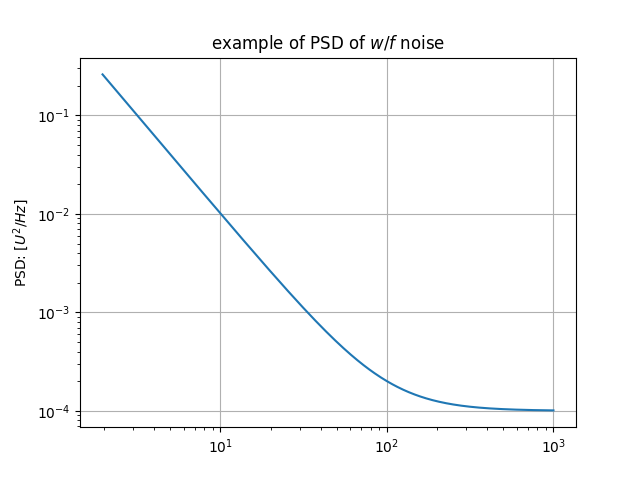

In [3]:
freq= np.linspace(0, 1000, 512)

def psd_white_1f(freq, sigma=1e-2, f_knee = 100, alpha = 2):
    # psd at 0 is 0
    psd = np.empty_like(freq)
    i_b = 0
    if freq[0] == 0:
        i_b = 1
        psd[0] = 0.0
    psd[i_b:] = (1 + np.power(f_knee/freq[i_b:],alpha ))*sigma**2
    return psd 

psd = psd_white_1f(freq)
print( psd[0])

plt.figure()
plt.title('example of PSD of $w/f$ noise')
plt.loglog(freq[1:], psd[1:])
plt.ylabel(r'PSD: [$U^2/Hz$]')
plt.grid()

By default $\sigma^2$ is 1e-4 and the unit is $U^2/Hertz$ where $U$ is the unit of time serie. This value will guide us to find the correct normalization through the different simulation methods.

# Generator of $w/f$ noise

## Method of coloring white noise

4 steps:
* create a white noise with normal random : w_n
* compute le FFT of w_n
* multiple it by sqrt(PSD), ie ASD (amplitude power spectrum)
* take the inverse FFT of the result

For FFT computation, we use the scipy implementation for real input signal, function `rfft()` with default normalization mode "backward", see [ref](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.rfft.html).


We will see that in this context the frequency of sampling of the white noise is important. Let's begin wihout normalization.

### With no normalization

In [4]:
n_s = 2048*8
f_s = 1500.0
f_n = f_s/2
w_noise = np.random.randn(n_s)
print(w_noise.mean(), w_noise.std())

-0.005750815530952516 0.9892461403560016


In [5]:
fft_w = sf.rfft(w_noise)
n_freq = fft_w.shape[0]
freq_fft =  np.linspace(0.0, f_n, n_freq )
print(freq_fft)

[0.00000000e+00 9.15527344e-02 1.83105469e-01 ... 7.49816895e+02
 7.49908447e+02 7.50000000e+02]


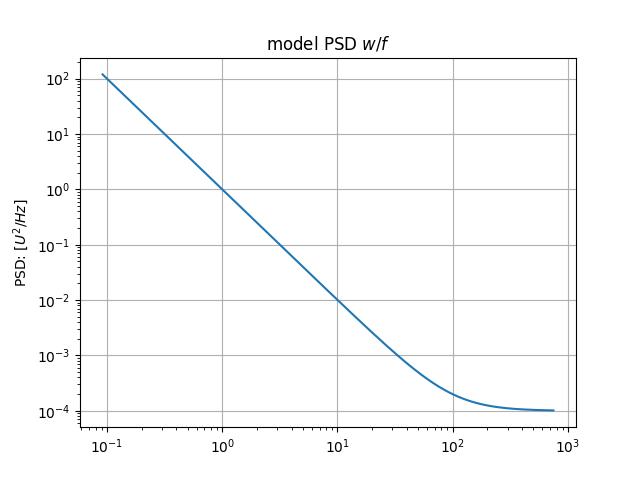

In [6]:
psd_i = psd_white_1f(freq_fft)
plt.figure()
plt.title('model PSD $w/f$')
plt.loglog(freq_fft[1:-2], psd_i[1:-2])
plt.ylabel(r'PSD: [$U^2/Hz$]')
plt.grid()

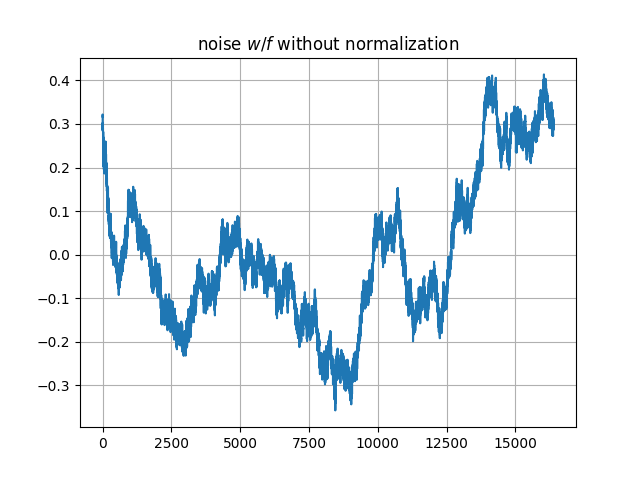

In [7]:
fft_c = fft_w*np.sqrt(psd_i)
noise_c = sf.irfft(fft_c)
plt.figure()
plt.title('noise $w/f$ without normalization')
plt.plot(noise_c)
plt.grid()

now it's PSD with Welch method provided by SciPy

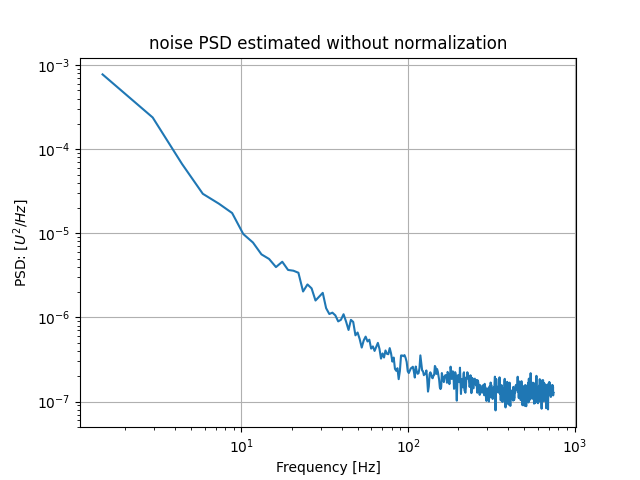

In [8]:
plot_psd(noise_c, f_s,"noise PSD estimated without normalization")

The flat part of PSD isn't 1e-4 as expected. Apply the "PSD normalization" factor   

### With normalization $\sqrt{\frac{f_s}{2}}$

In [9]:
# PSD normalization
fft_c *= np.sqrt(f_s/2)
noise_cn = sf.irfft(fft_c)

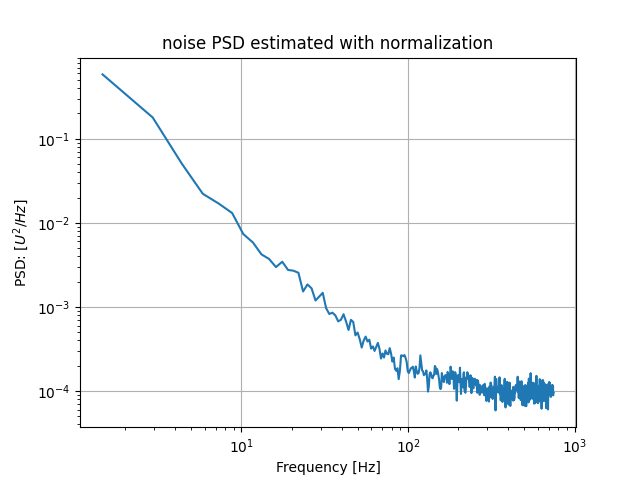

In [10]:
plot_psd(noise_cn, f_s,"noise PSD estimated with normalization")


We find the good value for high frequency of PSD.

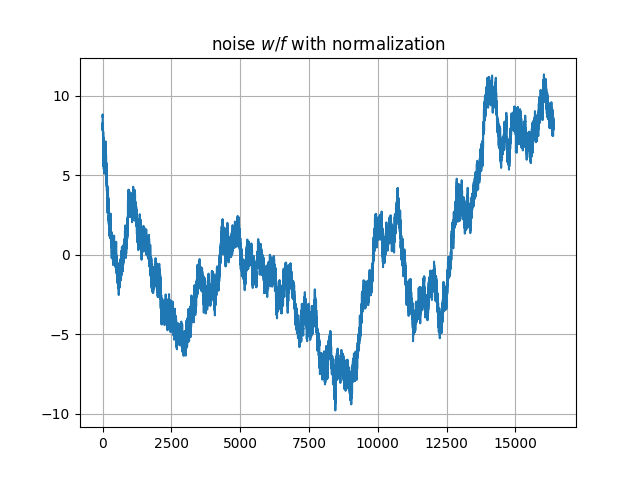

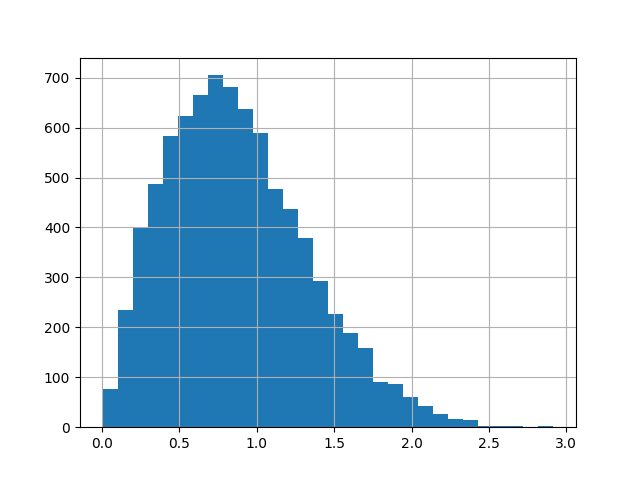

In [11]:
plt.figure()
plt.title('noise $w/f$ with normalization')
plt.plot(noise_cn)
plt.grid()

plt.figure()
plt.hist(np.abs(fft_w/np.sqrt(n_s)), 30)
plt.grid()

## Fast method with only inverse FFT

It's possible to improve the previous method whitout generate a normal noise in direct space. We define the FFT of the colored noise in polar representation where the module is the ASD and the phase in uniform random value. As we work directly in Fourier space, we must satisfy the default normalization (`"backward"`) by `rfft/irfft` SciPy function, ie $\sqrt{n_{sample}}$, see notebook `fft_and_white_noise.ipynb`.



In [ ]:
n_s = 2048*8
f_s = 1500.0
f_n = f_s/2

freq = sf.rfftfreq(n_s, 1/f_s)
modul = np.sqrt(psd_white_1f(freq))
angle = np.random.uniform(0,2*np.pi, len(freq))
# Mode 0 and Nyquist are real
angle[0], angle[-1] = 0, 0
fft_c = modul*np.exp(1j*angle)
fft_c *= np.sqrt(n_s)
fft_c *= np.sqrt(f_s/2)
noise_fast = sf.irfft(fft_c)

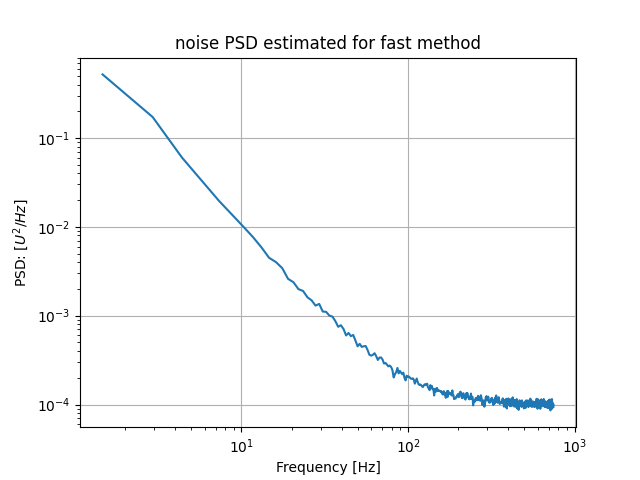

In [13]:
plot_psd(noise_fast, f_s, "noise PSD estimated for fast method")


The PSD is less noisy and closer to the model.

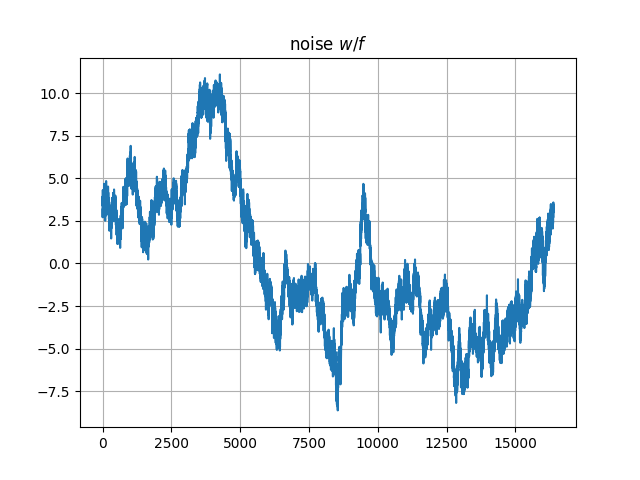

In [14]:
plt.figure()
plt.title('noise $w/f$')
plt.plot(noise_fast)
plt.grid()

# Comparaison


float64 (16384,)


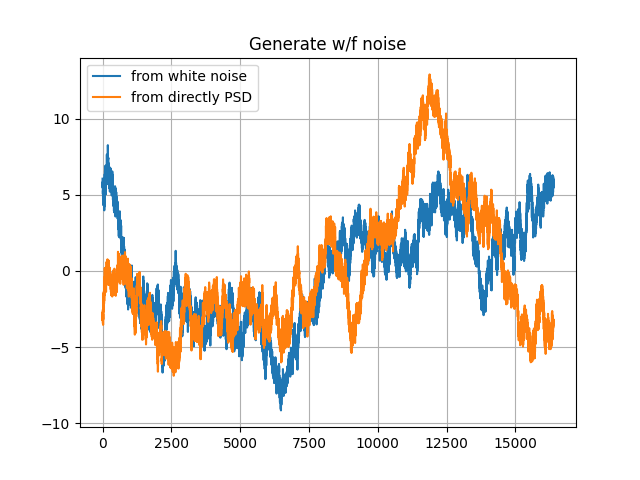

In [ ]:
def generate_from_wnoise(psd, n_s, f_s):
    """Generate from white noise

    Args:
        psd (float[]): Power Spectrum Density mode 0 to Nyquist 
        n_s (int): number of sample in time serie
        f_s (float): [Herz] sampling frequency 

    Returns:
        float[n_s]: time serie with same PSD as parameter psd
    """
    w_noise = np.random.randn(n_s)
    fft_w = sf.rfft(w_noise)
    # PSD normalisation : sqrt(f_s/2)
    fft_w *= np.sqrt(psd*f_s/2)
    return sf.irfft(fft_w)

def generate_from_psd(psd, n_s, f_s):
    """Generate in Fourier space with directly PSD as module

    Args:
        psd (float[]): Power Spectrum Density mode 0 to Nyquist 
        n_s (int): number of sample in time serie
        f_s (float): [Herz] sampling frequency 

    Returns:
        float[n_s]: time serie with same PSD as parameter psd
    """
    angle = np.random.uniform(0,2*np.pi, len(psd))
    # Mode 0 and Nyquist are real
    angle[0], angle[-1] = 0, 0
    # PSD normalisation : sqrt(f_s/2)
    # SciPy FFT backward normalisation : sqrt(n_s)
    fft_c = np.exp(1j*angle)*np.sqrt(psd*(n_s*f_s/2))
    return sf.irfft(fft_c)

n_s = 2048*8
f_s = 1500.0

freq = sf.rfftfreq(n_s, 1/f_s)
psd = psd_white_1f(freq)

n_wnoise = generate_from_wnoise(psd, n_s, f_s)
n_psd = generate_from_psd(psd, n_s,f_s)
print(n_psd.dtype, n_psd.shape)
plt.figure()
plt.title("Generate w/f noise")
plt.plot(n_wnoise, label="from white noise")
plt.plot(n_psd, label="directly from PSD")
plt.grid()
plt.legend()

In [16]:
%timeit generate_from_wnoise(psd, n_s, f_s)


499 µs ± 4.57 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [17]:
%timeit generate_from_psd(psd, n_s, f_s)

443 µs ± 13.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [18]:
454/376

1.2074468085106382

Method with random phase and ASD as module is 1.2 faster than generate white noise in direct space.